In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import itertools

In [26]:
df=pd.read_csv('product b.csv', parse_dates=['Month-Year'], index_col='Month-Year')

In [27]:
sales_b= df.drop(['Product Name','Product Category','Month','Year','Market Size', 'Marketing Expense','Month No.'],axis=1)

In [28]:
sales_b.shape

(60, 1)

In [29]:
sales_b.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 60 entries, 2019-01-01 to 2023-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   60 non-null     int64
dtypes: int64(1)
memory usage: 960.0 bytes


In [30]:
sales_b['Sales'].sum()

70016882

Text(0.5, 1.0, 'Product B')

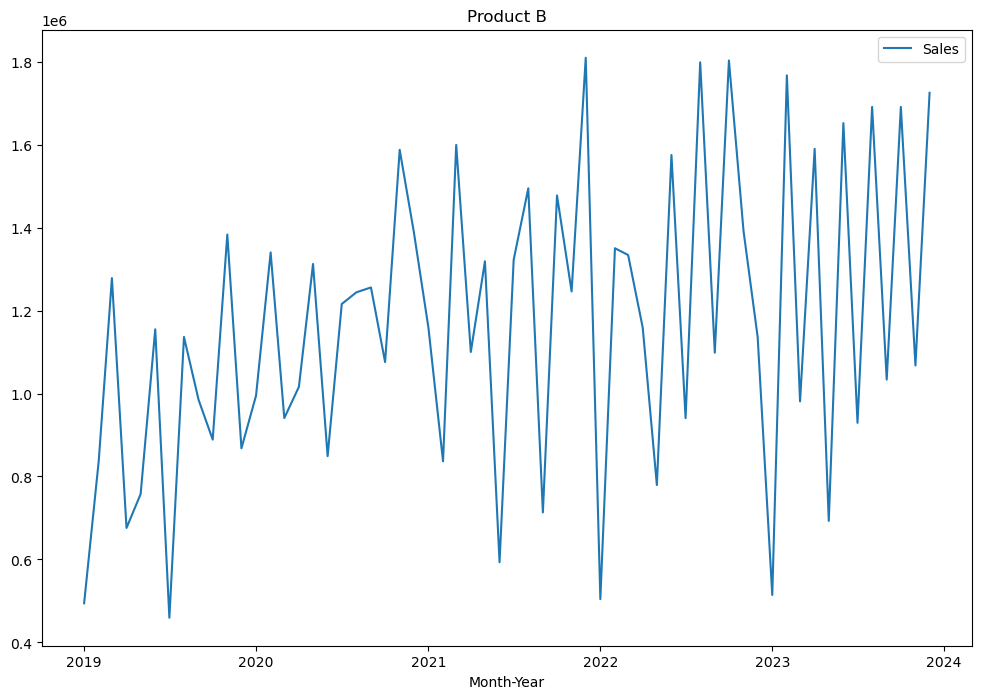

In [31]:
plt.figure(figsize=(12,8))
sns.lineplot(sales_b)
plt.title('Product B')

In [32]:
from statsmodels.tsa.stattools import adfuller

In [33]:
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [34]:
adf_test(sales_b)

ADF Statistics: -2.263078907366476
p- value: 0.18415230168794178
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [35]:
sales_b_diff= sales_b.diff().dropna()

Text(0.5, 1.0, 'Product B - First Difference')

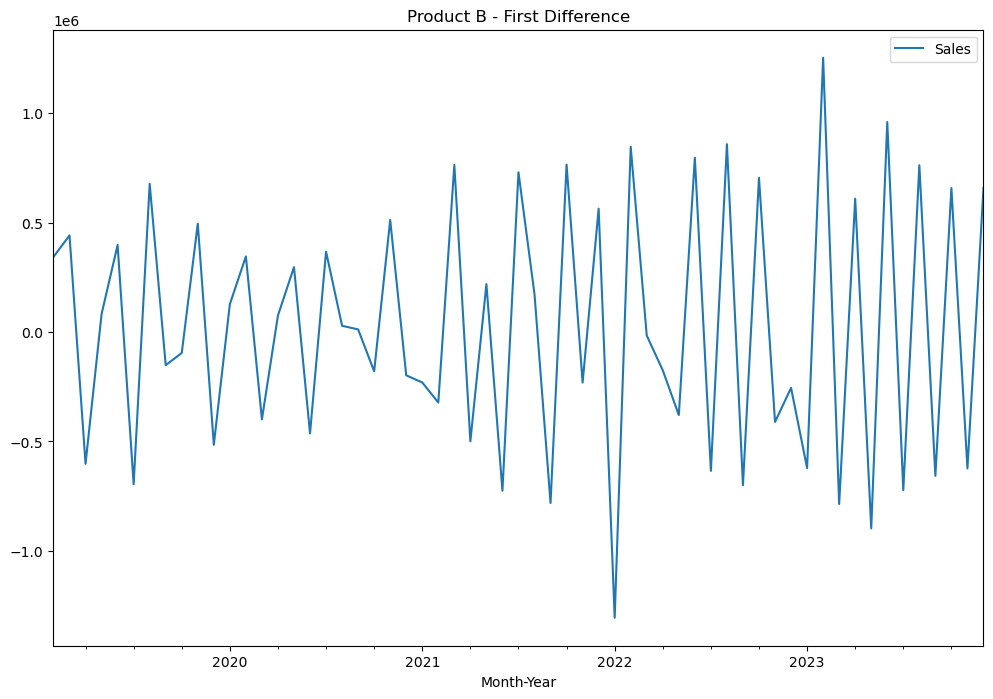

In [36]:
sales_b_diff.plot(figsize=(12,8))
plt.title('Product B - First Difference')

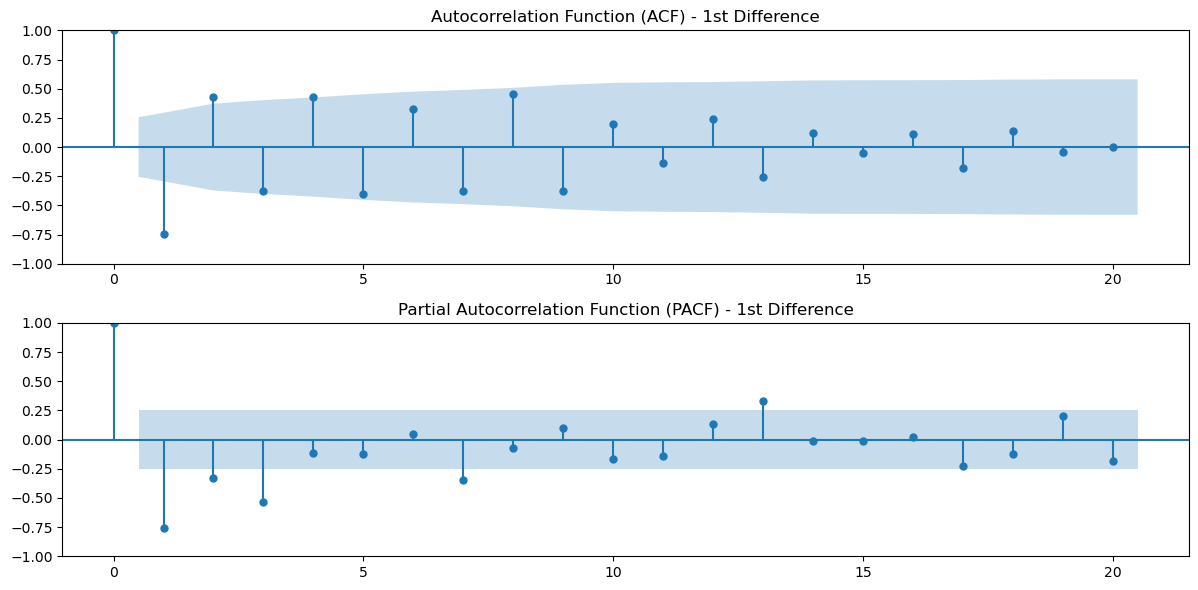

In [37]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_b_diff, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - 1st Difference')

plt.subplot(212)
plot_pacf(sales_b_diff, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - 1st Difference')

plt.tight_layout()
plt.show()

In [38]:
adf_test(sales_b_diff)

ADF Statistics: -10.617041136124557
p- value: 5.639859315327351e-19
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [39]:
train= sales_b[:48]
test=sales_b[48:]

In [40]:
len(train)

48

In [41]:
#Finding the best value for ARIMA

#import itertools
#p=d=q=range(0,5)
#pdq = list(itertools.product(p,d,q))

#for param in pdq:
#    try:
#        model_arima = ARIMA(train,order=param)
#        model_arima_fit = model_arima.fit()
#       print(param,model_arima_fit.aic)
#    except:
#        continue
    
# The Akaike information criterion (AIC) is an estimator of in-sample prediction error and thereby relative quality of
# statistical models for a given set of data

# It's like the mean squared error in Regression - The smaller the number, the better

In [42]:
#therefore, the combination p=(0,1,2,3,4,5) d=1 q=(0,1,2,3) must be tested with accuracy metrics and aic

In [43]:
#param = [(0,1,0),(0,1,1),(0,1,2),(0,1,3),(1,1,0),(1,1,1),(1,1,2),(1,1,3),(2,1,0), (2,1,1), (2,1,2),(2,1,3),(3,1,0),(3,1,1),(3,1,2),(3,1,3),(4,1,0),(4,1,1),(4,1,2),(4,1,3),(5,1,0),(5,1,1),(5,1,2),(5,1,3)]

#for p in param:  # Changed 'x' to 'p'
#    model = ARIMA(train, order=p).fit()
#    pred = model.forecast(steps=len(test))
#    mae = mean_absolute_error(test, pred)
#    mape = np.mean(np.abs((test - pred) / test)) * 100
#    mse=mean_squared_error(test, pred)
#    rmse = np.sqrt(mean_squared_error(test, pred))
#    print(p)
#    print(f'MAE: {mae}')
#    print(f'MSE: {mse}')
#    print(f'RMSE: {rmse}')
#    print('A.I.C:', model.aic)

In [44]:
order=[]
for p in range(6):
    # Loop over MA order
    for q in range(4):
        # Fit model        
#       model= ARIMA(sales_b, order=(p,1,q))
        model_t = ARIMA(train['Sales'], order=(p,1,q))
        model_test=model_t.fit() 
        pred=model_test.predict(start=len(train), end=(len(sales_b)-1))
        mae = mean_absolute_error(test, pred)
        mape = np.mean(np.abs((test - pred) / test)) * 100
        mse=mean_squared_error(test, pred)
        rmse = np.sqrt(mean_squared_error(test, pred))
        # Add order and scores to list        
        order.append((p, q, model_test.aic, model_test.bic,mae, mse, rmse))
#Make DataFrame of model order and AIC/BIC scores
order_df = pd.DataFrame(order, columns=['p','q', 'aic', 'bic', 'mae','mse', 'rmse'])

In [45]:
# Sort by AIC
print(order_df.sort_values('aic'))

    p  q          aic          bic            mae           mse           rmse
2   0  2  1335.335983  1340.886426  415980.172585  2.194360e+11  468439.970656
15  3  3  1335.516318  1348.467352  395385.399426  2.045460e+11  452267.593275
3   0  3  1336.320463  1343.721054  416898.596160  2.203126e+11  469374.681629
12  3  0  1336.799287  1344.199877  400609.449669  2.040767e+11  451748.443504
16  4  0  1337.030661  1346.281399  421541.921313  2.279173e+11  477406.893866
13  3  1  1337.119815  1346.370553  409544.081538  2.131751e+11  461708.939920
6   1  2  1337.390203  1344.790793  416664.192361  2.200180e+11  469060.799613
5   1  1  1337.590355  1343.140798  419677.801261  2.089984e+11  457163.446442
7   1  3  1338.322726  1347.573464  416932.811263  2.203524e+11  469417.049090
11  2  3  1338.338009  1349.438895  414263.110250  2.078226e+11  455875.688201
9   2  1  1338.539489  1345.940080  418030.378118  2.152384e+11  463937.899458
20  5  0  1338.642391  1349.743277  431848.802410  2

In [46]:
m_arima= ARIMA(train, order=(0,1,2))
model_arima=m_arima.fit()
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   48
Model:                 ARIMA(0, 1, 2)   Log Likelihood                -664.668
Date:                Thu, 09 May 2024   AIC                           1335.336
Time:                        14:55:02   BIC                           1340.886
Sample:                    01-01-2019   HQIC                          1337.425
                         - 12-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2259      0.131     -9.353      0.000      -1.483      -0.969
ma.L2          0.4343      0.142      3.053      0.002       0.156       0.713
sigma2      8.792e+10   4.92e-13   1.79e+23      0.0

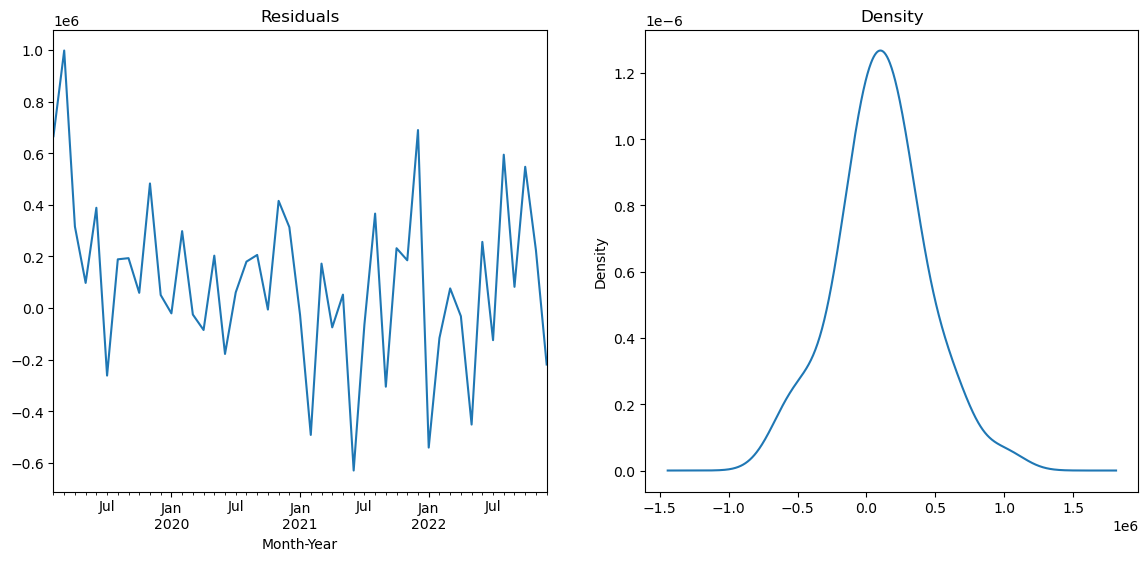

In [47]:
residuals= model_arima.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals.plot(title='Residuals',ax=ax[0])
residuals.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

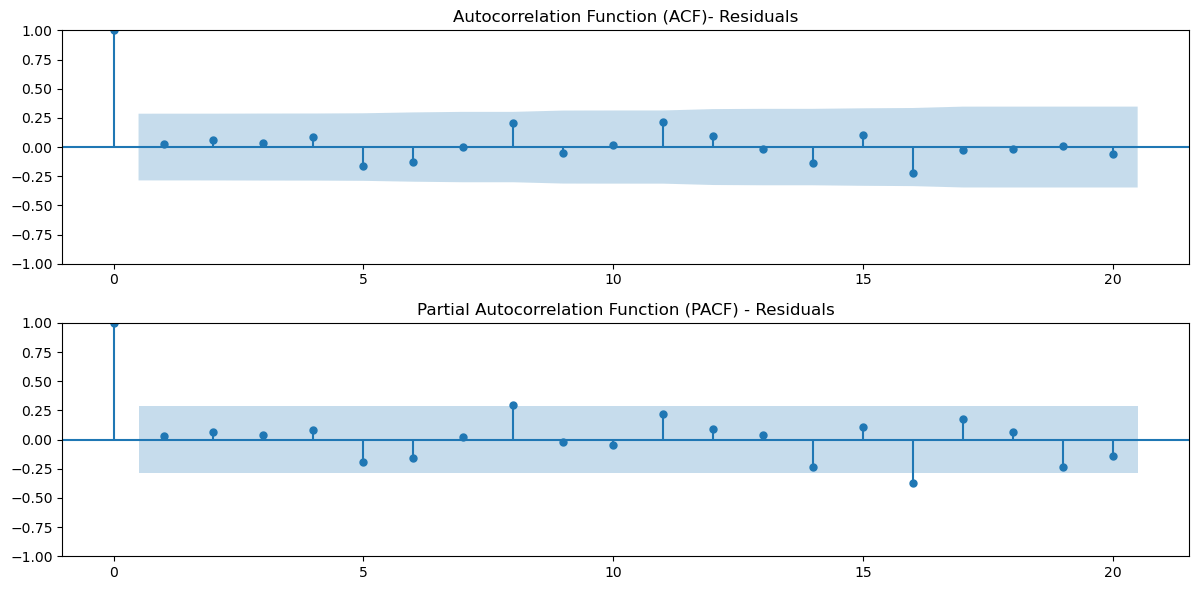

In [48]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation Function (ACF)- Residuals')

plt.subplot(212)
plot_pacf(residuals, lags=20, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Residuals')

plt.tight_layout()
plt.show()

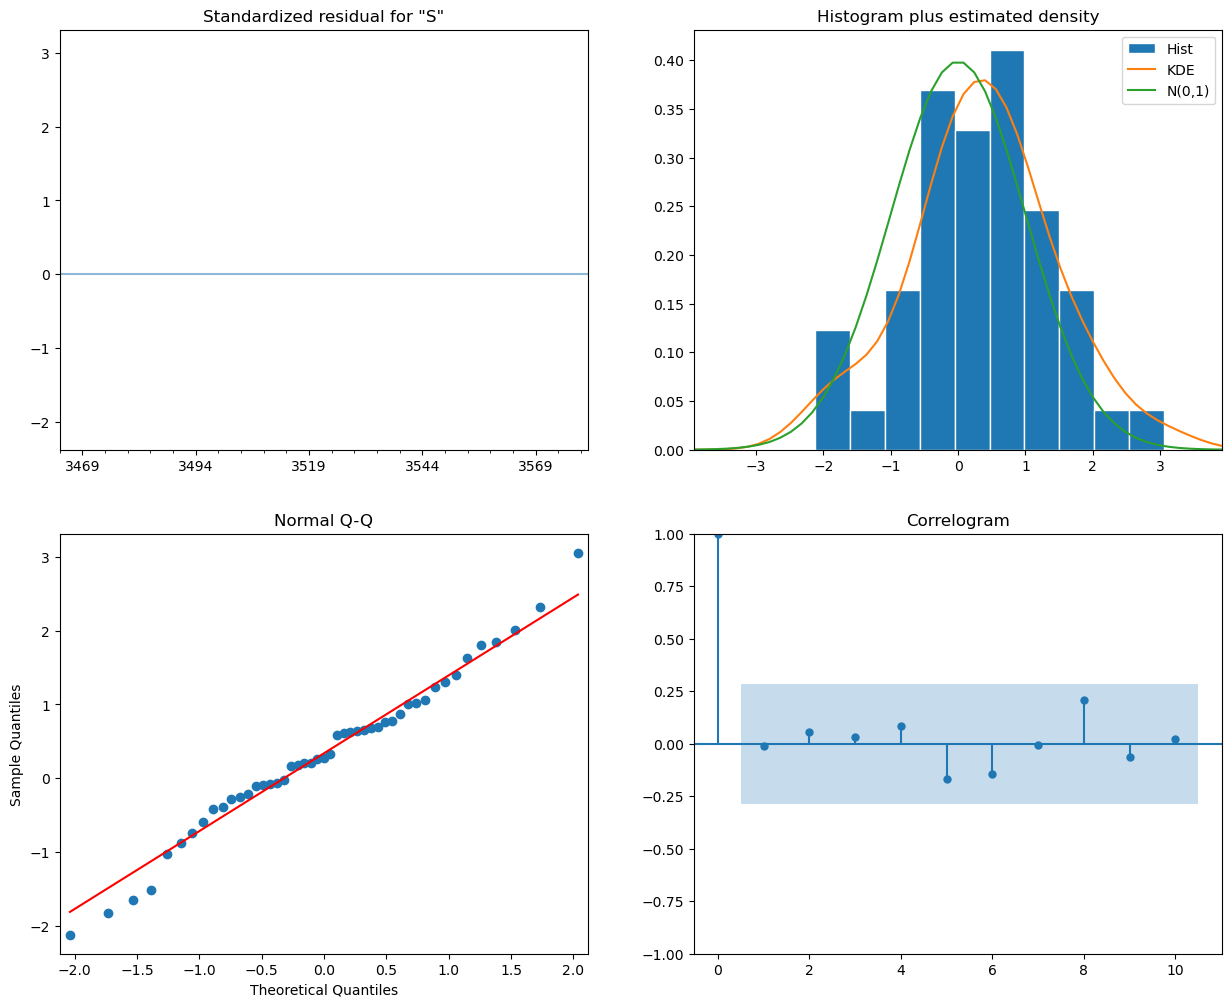

In [49]:
# Create the 4 diagostics plots
model_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [50]:
#pred_in_sample = model_arima.get_prediction(start=len(train), end=(len(sales_b)-1))
#sales_b['Forecast_ARIMA_p']=[None]*len(train) + list(pred)

In [51]:
#plt.figure(figsize=(12, 8))
#sns.lineplot(sales_b[['Sales','Forecast_ARIMA_p']])
#plt.title('Product B')
#plt.show()

In [52]:
pred=model_arima.predict(start=len(train), end=(len(sales_b)-1), dynamic = True)
sales_b['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_b.plot()

In [53]:
#pred=model_arima.forecast(steps= len(test))
#sales_b['Forecast_ARIMA']=[None]*len(train) + list(pred)
#sales_b.plot()

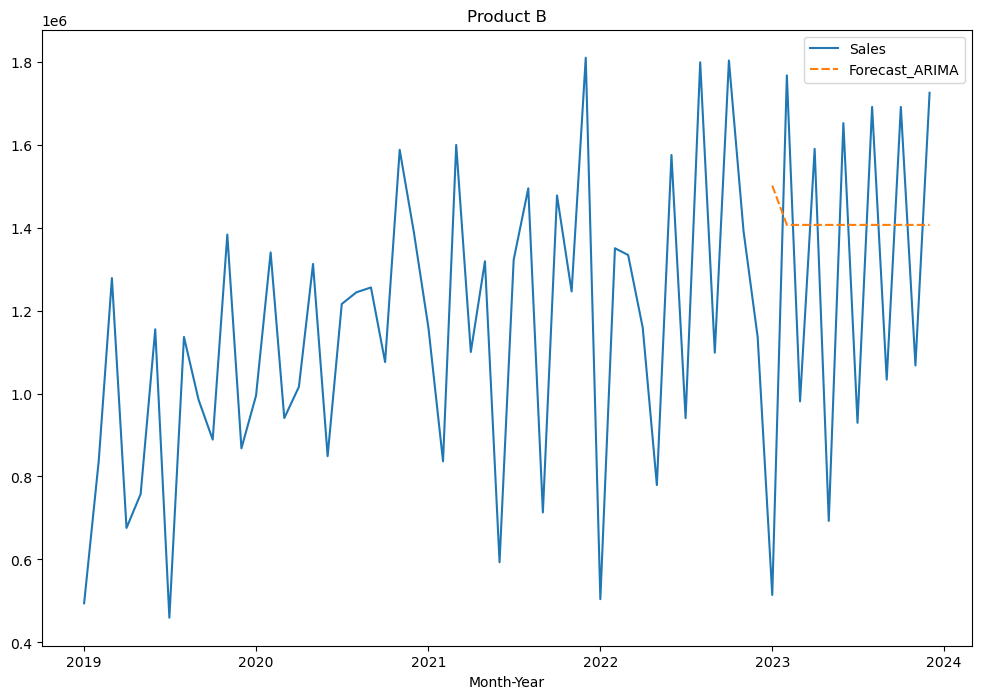

In [54]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_ARIMA']])
plt.title('Product B')
plt.show()

In [55]:
mae_arima= mean_absolute_error(test,pred)
mse_arima=mean_squared_error(test, pred)
mape_arima= mean_absolute_percentage_error(test,pred)
rmse_arima= np.sqrt(mean_squared_error(test,pred))

print(f'MAE - ARIMA: {mae_arima}')
print(f'MAPE - ARIMA: {mape_arima}')
print(f'MSE - ARIMA: {mse_arima}')
print(f'RMSE - ARIMA: {rmse_arima}')

MAE - ARIMA: 415980.172584766
MAPE - ARIMA: 0.46360256183898624
MSE - ARIMA: 219436006108.1432
RMSE - ARIMA: 468439.9706559456


# FORECASTING

In [56]:
f_arima= ARIMA(sales_b['Sales'], order=(0,1,2))
model_f_arima=f_arima.fit()

In [57]:
forecast_=model_f_arima.predict(start=len(sales_b), end=(len(sales_b)+11), dynamic = True)

In [58]:
forecast_

2024-01-01    1.215687e+06
2024-02-01    1.378558e+06
2024-03-01    1.378558e+06
2024-04-01    1.378558e+06
2024-05-01    1.378558e+06
2024-06-01    1.378558e+06
2024-07-01    1.378558e+06
2024-08-01    1.378558e+06
2024-09-01    1.378558e+06
2024-10-01    1.378558e+06
2024-11-01    1.378558e+06
2024-12-01    1.378558e+06
Freq: MS, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'Product B')

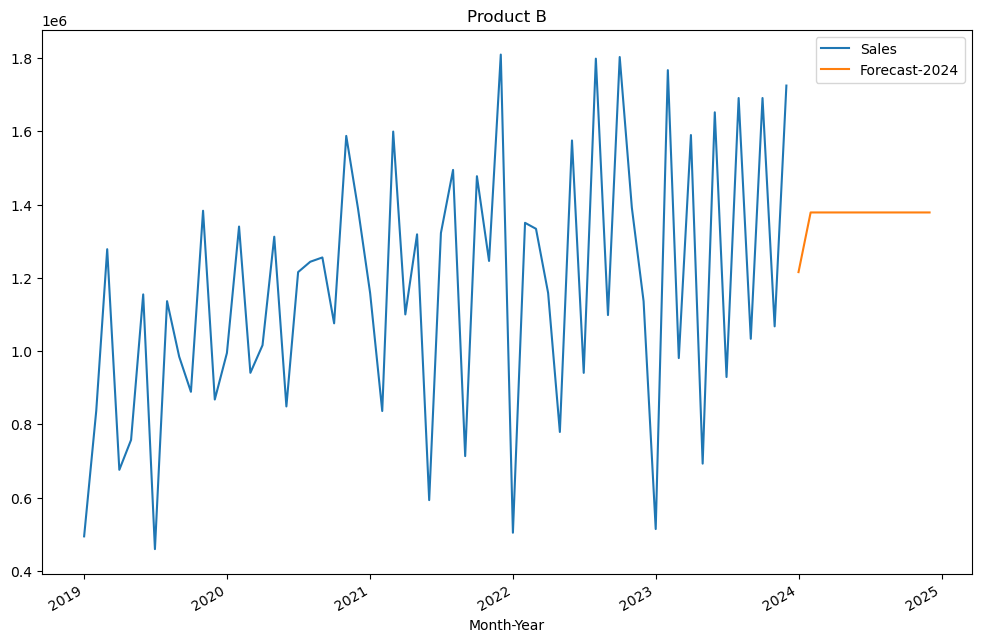

In [59]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
forecast_.plot(legend=True, label='Forecast-2024')
plt.title('Product B')

In [60]:
arima_forecast_model=model_f_arima.get_forecast(steps=12)

In [61]:
mean_forecast= arima_forecast_model.predicted_mean
dates = mean_forecast.index

In [62]:
confidence_intervals= arima_forecast_model.conf_int()

In [63]:
print(mean_forecast,confidence_intervals)

2024-01-01    1.215687e+06
2024-02-01    1.378558e+06
2024-03-01    1.378558e+06
2024-04-01    1.378558e+06
2024-05-01    1.378558e+06
2024-06-01    1.378558e+06
2024-07-01    1.378558e+06
2024-08-01    1.378558e+06
2024-09-01    1.378558e+06
2024-10-01    1.378558e+06
2024-11-01    1.378558e+06
2024-12-01    1.378558e+06
Freq: MS, Name: predicted_mean, dtype: float64               lower Sales   upper Sales
2024-01-01  359711.287925  2.071662e+06
2024-02-01  492635.903261  2.264480e+06
2024-03-01  480738.473972  2.276377e+06
2024-04-01  468996.654551  2.288119e+06
2024-05-01  457404.494364  2.299711e+06
2024-06-01  445956.412639  2.311160e+06
2024-07-01  434647.167059  2.322469e+06
2024-08-01  423471.825703  2.333644e+06
2024-09-01  412425.741914  2.344690e+06
2024-10-01  401504.531713  2.355611e+06
2024-11-01  390704.053477  2.366412e+06
2024-12-01  380020.389580  2.377096e+06


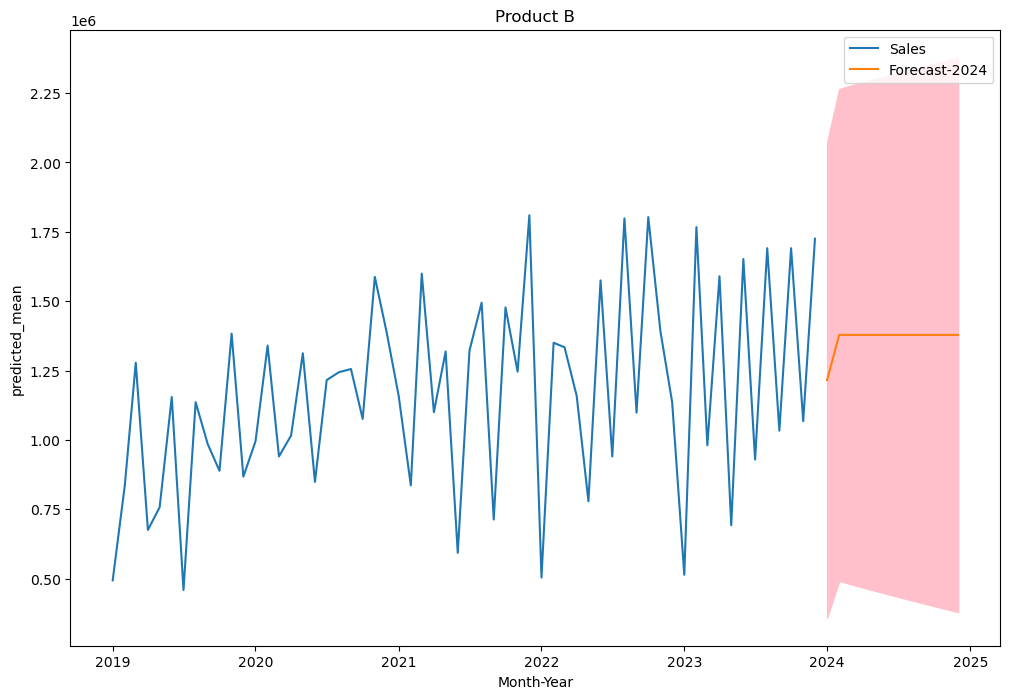

In [64]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
sns.lineplot(mean_forecast,label='Forecast-2024')
#plt.plot(mean_forecast,color='red',label='Forecast-2024')
plt.fill_between(dates,confidence_intervals['lower Sales'],confidence_intervals['upper Sales'],color='pink')
plt.title('Product B')
plt.show()

# SARIMA

In [65]:
import statsmodels.api as sm

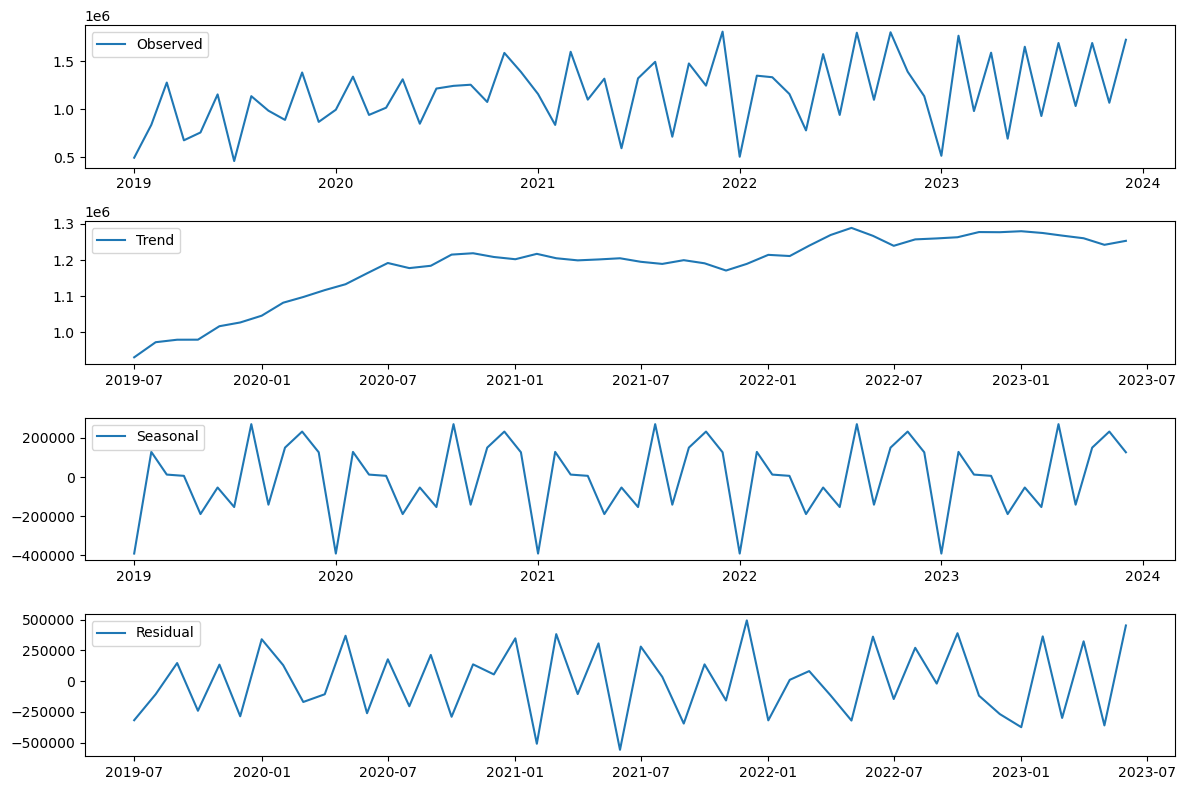

In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
decomposition = seasonal_decompose(sales_b['Sales'], model='additive', period=12)

# Plot the decomposition
#fig = decomposition.plot(figsize=(12,8))
#plt.show()
# Create a new figure with the specified size
plt.figure(figsize=(12, 8))

# Plot each component separately
plt.subplot(411)
plt.plot(decomposition.observed, label='Observed')
plt.legend()

plt.subplot(412)
plt.plot(decomposition.trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(decomposition.resid, label='Residual')
plt.legend()

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

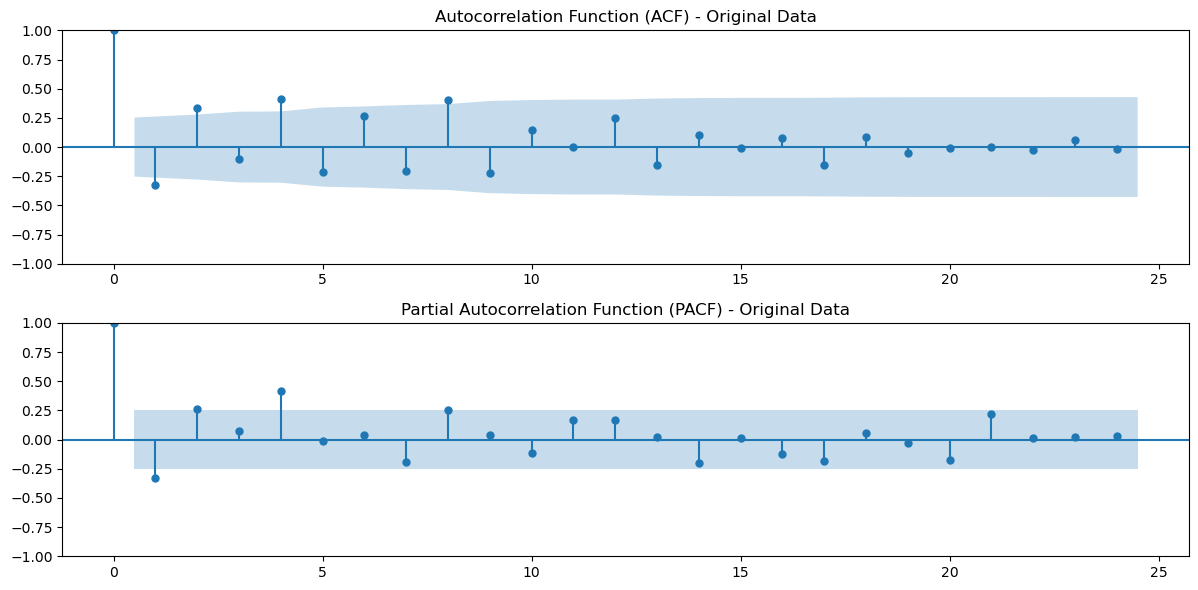

In [92]:
# Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(sales_b['Sales'], lags=24, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) - Original Data')

plt.subplot(212)
plot_pacf(sales_b['Sales'], lags=24, ax=plt.gca())
plt.title('Partial Autocorrelation Function (PACF) - Original Data')

plt.tight_layout()
plt.show()

In [68]:
# Plot
#fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
#axes[0].plot(sales_b['Sales'], label='Original Series')
#axes[0].plot(sales_b['Sales'].diff(1), label='Usual Differencing')
#axes[0].set_title('Usual Differencing')
#axes[0].legend(loc='upper left', fontsize=10)


# Seasinal Dei
#axes[1].plot(sales_b['Sales'], label='Original Series')
#axes[1].plot(sales_b['Sales'].diff(12), label='Seasonal Differencing', color='green')
#axes[1].set_title('Seasonal Differencing')
#plt.legend(loc='upper left', fontsize=10)
#plt.suptitle('Product B', fontsize=16)
#plt.show()

In [69]:
# Plot ACF and PACF
#plt.figure(figsize=(12, 6))
#plt.subplot(211)
#plot_acf(sales_b['Sales'].diff(12).dropna(), lags=22, ax=plt.gca())
#plt.title('Autocorrelation Function (ACF) - Seasonal Difference')

#plt.subplot(212)
#plot_pacf(sales_b['Sales'].diff(12).dropna(), lags=22, ax=plt.gca())
#plt.title('Partial Autocorrelation Function (PACF) - Seasonal Difference')

#plt.tight_layout()
#plt.show()

In [70]:
#b=sales_b['Sales'].diff(12).dropna()

In [71]:
#adf_test(b)

In [72]:
order_SARIMAX=[]
# Loop over P order
for P in range(3):
    # Loop over Q order
    for Q in range(3):
        # Fit model
        model_s = sm.tsa.statespace.SARIMAX(train['Sales'], order=(0, 1, 2), seasonal_order=(P, 0, Q, 12))
        model_test_s = model_s.fit() 
        pred = model_test_s.predict(start=48, end=59, dynamic=True)
        mae = mean_absolute_error(test, pred)
        mse = mean_squared_error(test, pred)
        # Add order and scores to list        
        order_SARIMAX.append((P, Q, model_test_s.aic, model_test_s.bic, mae, mse))

# Make DataFrame of model order and scores
order_SARIMAX_df = pd.DataFrame(order_SARIMAX, columns=['P', 'Q', 'aic', 'bic', 'mae', 'mse'])


In [73]:
# Sort by AIC
print(order_SARIMAX_df.sort_values('aic'))

   P  Q          aic          bic            mae           mse
1  0  1  1334.498027  1341.898617  351873.141253  1.619751e+11
3  1  0  1334.711664  1342.112255  358036.379541  1.657979e+11
0  0  0  1335.335983  1340.886426  415980.172585  2.194360e+11
4  1  1  1336.481829  1345.732567  353613.954793  1.635244e+11
2  0  2  1336.485323  1345.736061  353033.231522  1.630799e+11
6  2  0  1336.622008  1345.872746  354033.263538  1.632783e+11
7  2  1  1338.474795  1349.575681  354372.385105  1.637058e+11
5  1  2  1338.480512  1349.581397  353827.960953  1.636124e+11
8  2  2  1339.446305  1352.397339  367435.416484  1.774739e+11


In [74]:
sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(0, 1, 2),seasonal_order=(0,0,1,12))
sarima_model=sarima.fit()

In [75]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 12)   Log Likelihood                -663.249
Date:                              Thu, 09 May 2024   AIC                           1334.498
Time:                                      14:55:17   BIC                           1341.899
Sample:                                  01-01-2019   HQIC                          1337.283
                                       - 12-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2898      0.134     -9.604      0.000      -1.553      -1.027
ma.L2          0.4827      0.142      3.394      0.001       0.204       0.762
ma.S.L12       0.3132      0.172      1.819      0.069      -0.024       0.651
sigma2      8.792e+10   9.88e-13    8.9e+22      0.000    8.79e+10    8.79e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.24
Prob(Q):                              0.98   Prob(JB):                         0.89
Heteroskedasticity (H):               1.11   Skew:                            -0.17
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.84e+38. Standard errors may be unstable.
"""

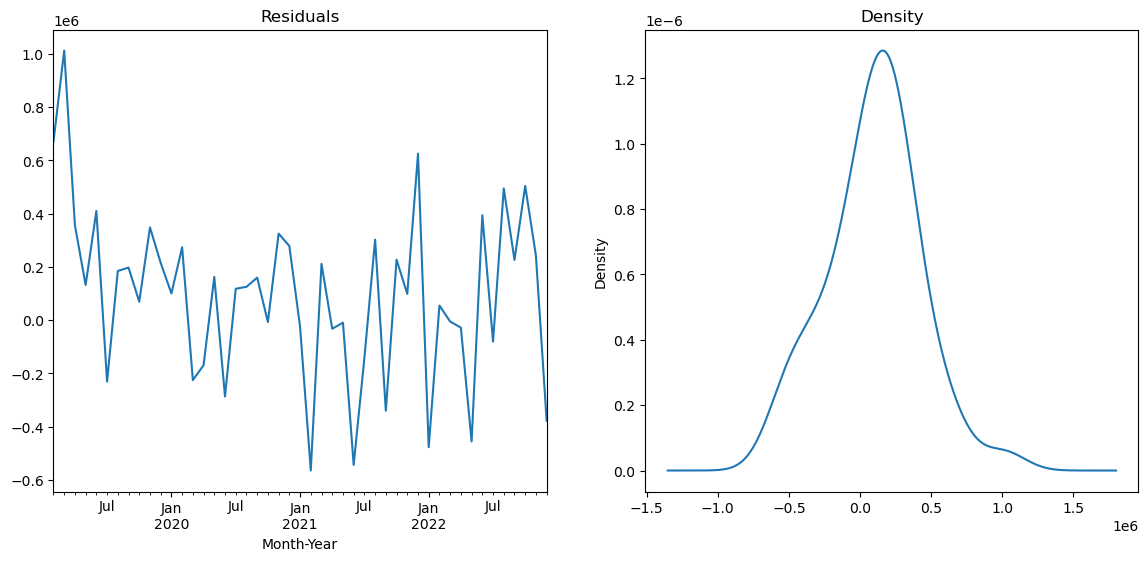

In [76]:
residuals_s= sarima_model.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals_s.plot(title='Residuals',ax=ax[0])
residuals_s.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

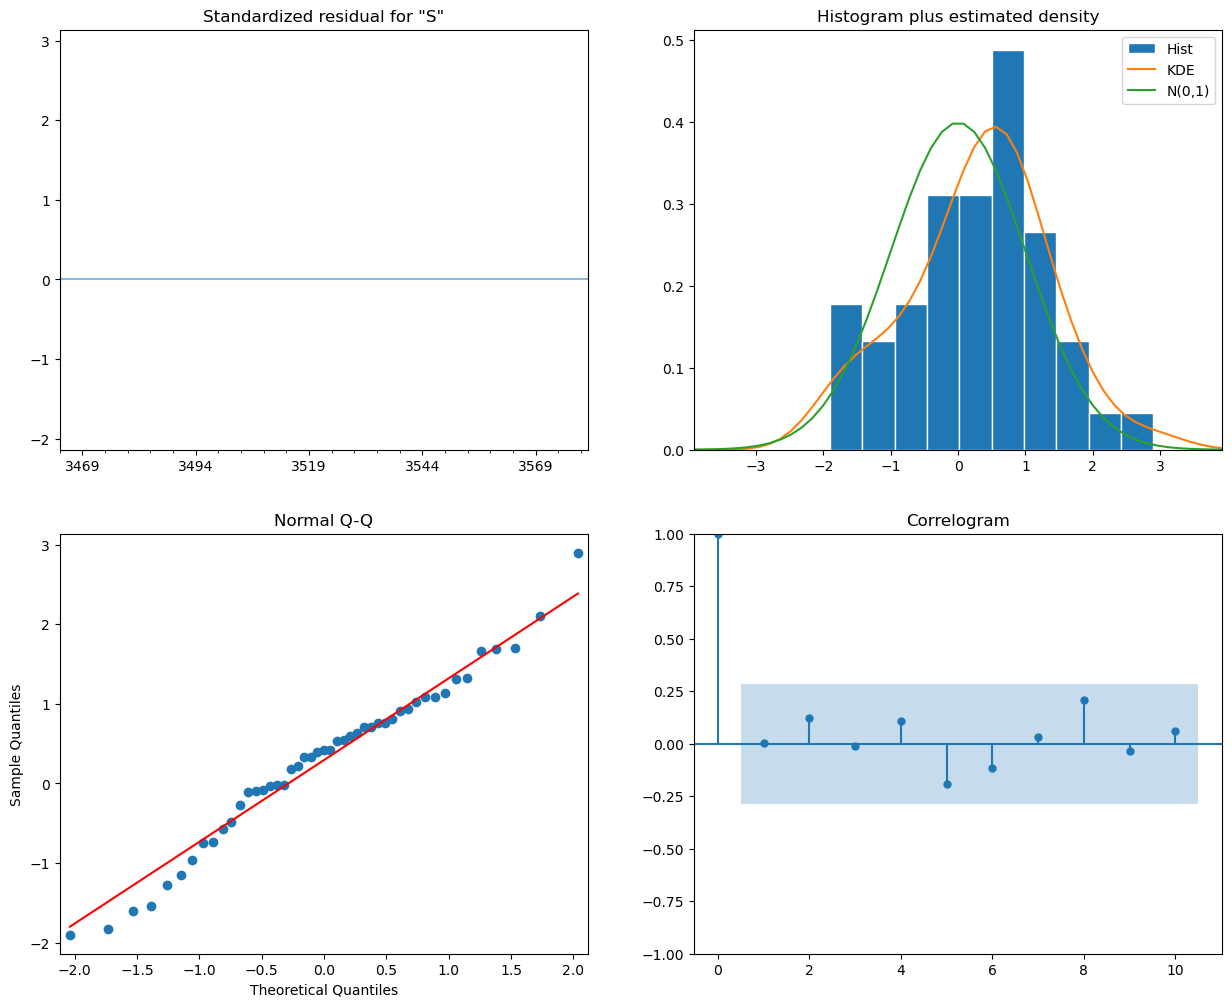

In [77]:
sarima_model.plot_diagnostics(figsize=(15, 12))
plt.show()

In [78]:
forecast_test_sarima=sarima_model.predict(start=48,end=59,dynamic=True)

In [79]:
sales_b['Forecast_SARIMA']=[None]*len(train)+ list(forecast_test_sarima)
#sales_b[['Sales','Forecast_SARIMA']].plot(figsize=(12,8))

Text(0.5, 1.0, 'Product B')

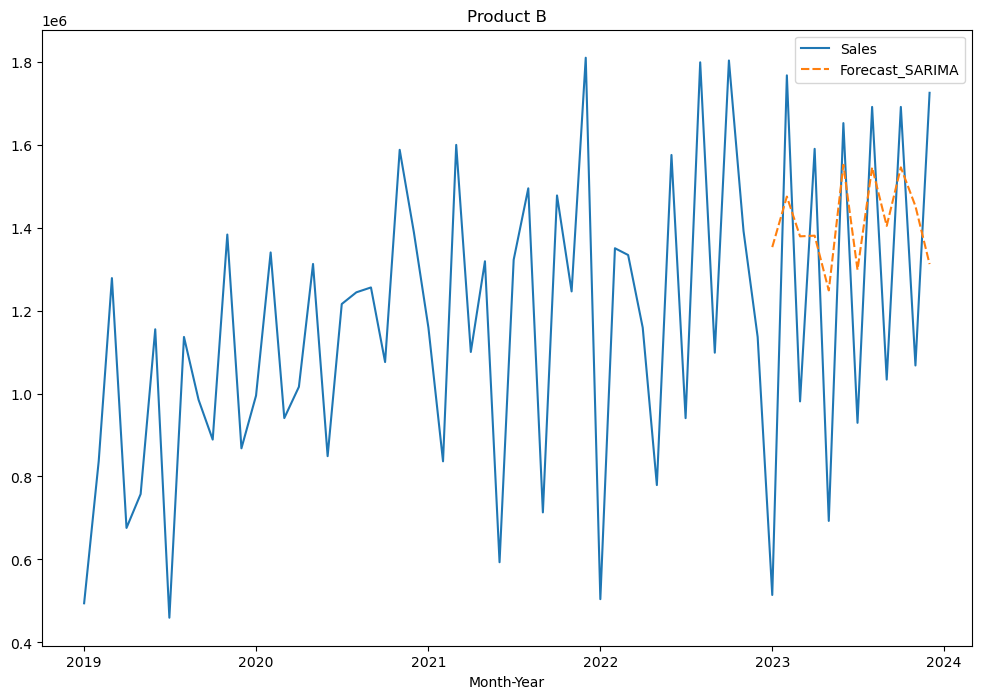

In [80]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_SARIMA']])
plt.title('Product B')

In [81]:
mae_sarima= mean_absolute_error(test,forecast_test_sarima)
mape_sarima= mean_absolute_percentage_error(test,forecast_test_sarima)
mse_sarima=mean_squared_error(test, forecast_test_sarima)
rmse_sarima= np.sqrt(mean_squared_error(test,forecast_test_sarima))

print(f'MAE - SARIMA: {round(mae_sarima,3)}')
print(f'MAPE - SARIMA: {round(mape_sarima,3)}')
print(f'MSE - SARIMA: {round(mse_sarima,3)}')
print(f'RMSE - SARIMA: {round(rmse_sarima,3)}')

MAE - SARIMA: 351873.141
MAPE - SARIMA: 0.394
MSE - SARIMA: 161975143463.294
RMSE - SARIMA: 402461.356


# FORECASTING

In [80]:
sarima_forecast=sm.tsa.statespace.SARIMAX(sales_b['Sales'],order=(0, 1, 2),seasonal_order=(0,0,1,12))
sarima_model_f=sarima_forecast.fit()

In [81]:
forecast_sarima=sarima_model_f.predict(start=60,end=71,dynamic=True)

In [82]:
forecast_sarima

2024-01-01    9.502839e+05
2024-02-01    1.476477e+06
2024-03-01    1.253375e+06
2024-04-01    1.451433e+06
2024-05-01    1.202631e+06
2024-06-01    1.412662e+06
2024-07-01    1.263047e+06
2024-08-01    1.428616e+06
2024-09-01    1.260136e+06
2024-10-01    1.428619e+06
2024-11-01    1.255599e+06
2024-12-01    1.520207e+06
Freq: MS, Name: predicted_mean, dtype: float64

Text(0.5, 1.0, 'Product B')

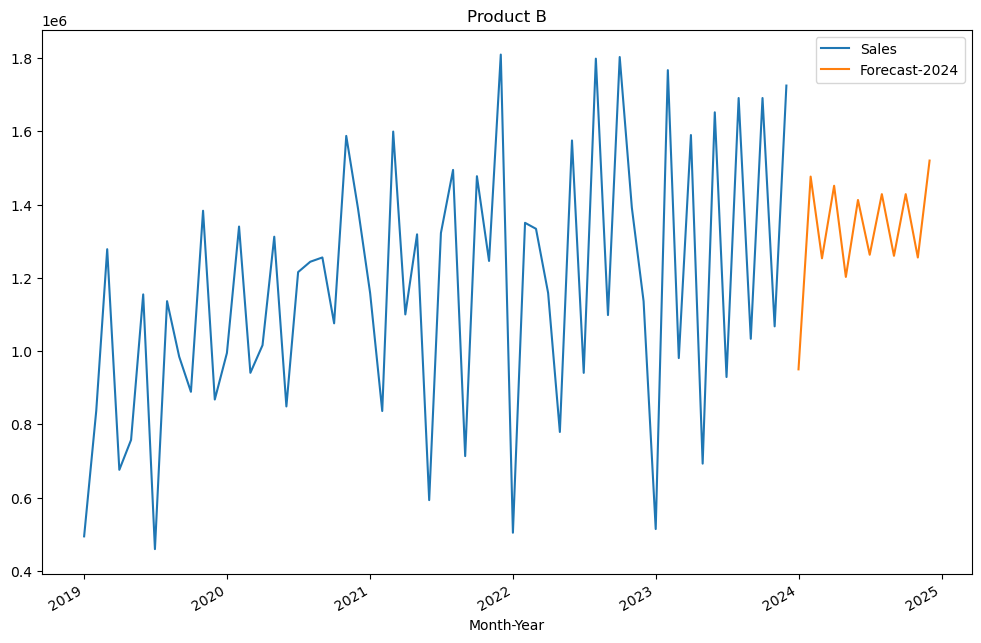

In [83]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
forecast_sarima.plot(legend=True, label='Forecast-2024')
plt.title('Product B')

In [84]:
sarima_forecast_model=sarima_model_f.get_forecast(steps=12)

In [85]:
mean_forecast_sarima= sarima_forecast_model.predicted_mean
dates = mean_forecast_sarima.index

In [86]:
confidence_intervals_sarima= sarima_forecast_model.conf_int()

In [87]:
print(mean_forecast_sarima,confidence_intervals_sarima)

2024-01-01    9.502839e+05
2024-02-01    1.476477e+06
2024-03-01    1.253375e+06
2024-04-01    1.451433e+06
2024-05-01    1.202631e+06
2024-06-01    1.412662e+06
2024-07-01    1.263047e+06
2024-08-01    1.428616e+06
2024-09-01    1.260136e+06
2024-10-01    1.428619e+06
2024-11-01    1.255599e+06
2024-12-01    1.520207e+06
Freq: MS, Name: predicted_mean, dtype: float64               lower Sales   upper Sales
2024-01-01   94306.611068  1.806261e+06
2024-02-01  586501.774422  2.366453e+06
2024-03-01  352330.260581  2.154420e+06
2024-04-01  539453.191977  2.363413e+06
2024-05-01  279846.125350  2.125416e+06
2024-06-01  479196.297048  2.346127e+06
2024-07-01  319022.157532  2.207072e+06
2024-08-01  474148.921100  2.383084e+06
2024-09-01  295338.772991  2.224933e+06
2024-10-01  453601.294536  2.403636e+06
2024-11-01  270467.330825  2.240731e+06
2024-12-01  525064.668172  2.515349e+06


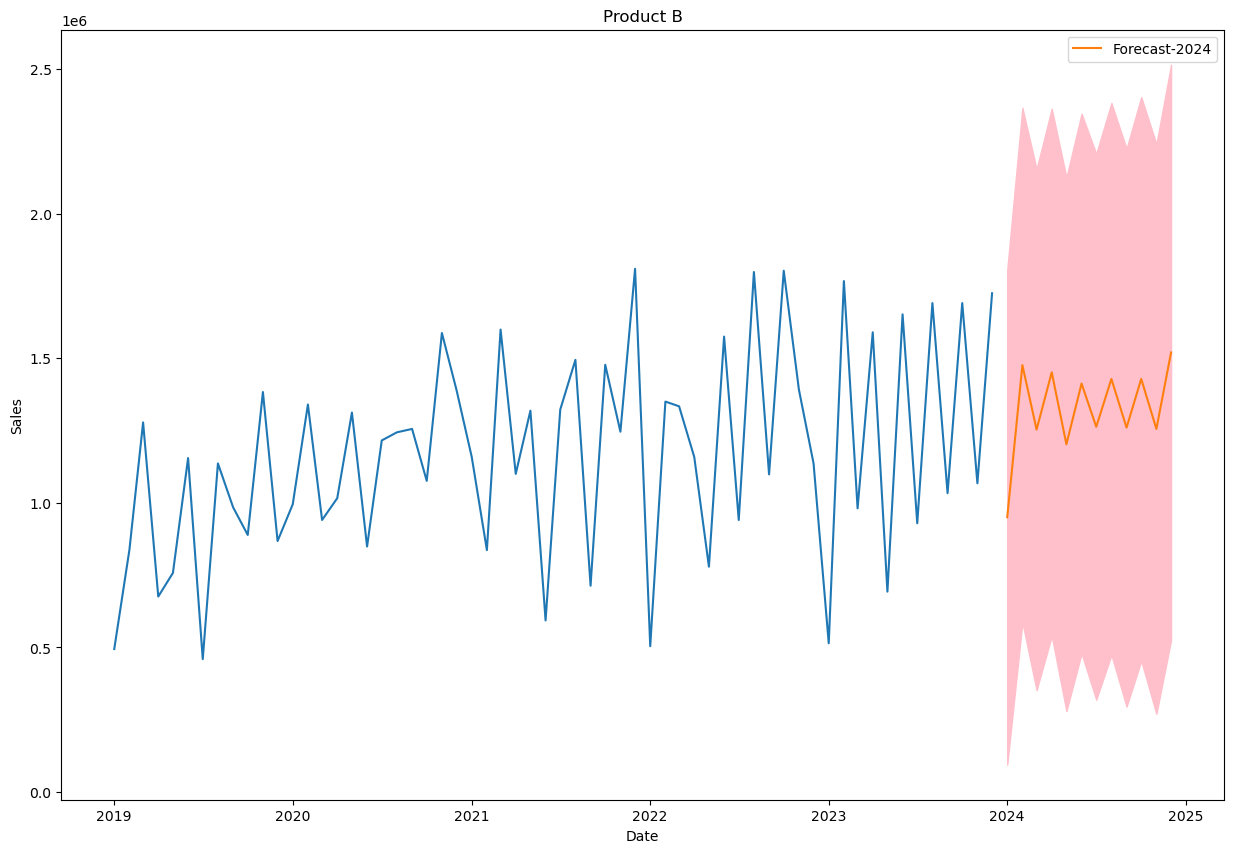

In [90]:
plt.figure(figsize=(15, 10))
sns.lineplot(data=sales_b['Sales'])  # Assuming 'Sales' is a column in your sales_b DataFrame
sns.lineplot(data=mean_forecast_sarima, label='Forecast-2024')
plt.fill_between(x=mean_forecast_sarima.index, y1=confidence_intervals_sarima['lower Sales'], y2=confidence_intervals_sarima['upper Sales'], color='pink')
plt.title('Product B')
plt.xlabel('Date')  # Assuming you want to label the x-axis with 'Date'
plt.ylabel('Sales')  # Assuming you want to label the y-axis with 'Sales'
plt.legend()  # Adding a legend to differentiate between the actual sales and forecast
plt.show()


# AUTO-ARIMA

In [83]:
import pmdarima as pm

In [84]:
auto_arima= pm.auto_arima(train, start_p=0, d=1, start_q=0, max_p=5,max_q=3,
                          start_P=0, D=0, start_Q=0, max_P=5 ,max_Q=5 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1374.393, Time=0.02 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1376.384, Time=0.05 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1377.119, Time=0.19 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=1378.474, Time=0.41 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=1380.446, Time=2.52 sec
 ARIMA(0,1,0)(0,0,5)[12] intercept   : AIC=1382.419, Time=2.95 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1376.387, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1378.263, Time=0.14 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1378.671, Time=0.33 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=1380.457, Time=0.71 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=1382.435, Time=4.52 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1377.144, Time=0.12 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1378.530, Time=0.25 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1380.459, Time=0.47 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=1382.426, Time=1.72

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

In [85]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(3, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -660.560
Date:                            Thu, 09 May 2024   AIC                           1335.120
Time:                                    14:56:59   BIC                           1348.071
Sample:                                01-01-2019   HQIC                          1339.994
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.218e+04   2.76e+04      1.529      0.126   -1.19e+04    9.63e+04
ar.L1         -0.7728      0.212     -3.647      0.000      -1.188      -0.358
ar.L2         -0.4947      0.256     -1.934      0.053      -0.996       0.007
ar.L3         -0.3294      0.161     -2.051      0.040      -0.644      -0.015
ma.L1         -0.6157      0.175     -3.516      0.000      -0.959      -0.272
ma.S.L12       0.3138      0.234      1.340      0.180      -0.145       0.773
sigma2       8.38e+10      0.007   1.17e+13      0.000    8.38e+10    8.38e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.40   Prob(JB):                         0.64
Heteroskedasticity (H):               1.03   Skew:                            -0.17
Prob(H) (two-sided):                  0.96   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.21e+29. Standard errors may be unstable.
"""

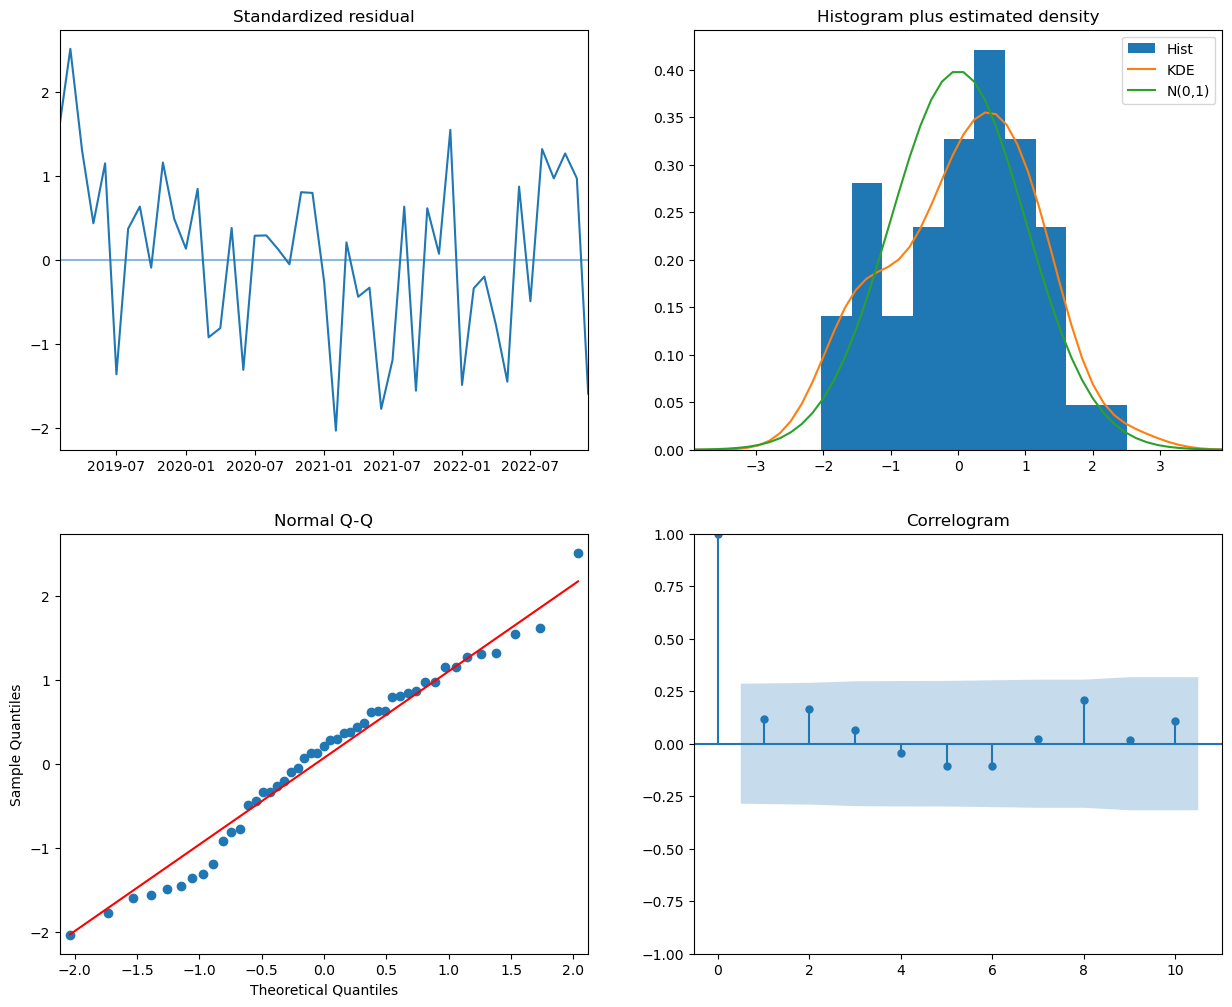

In [86]:
auto_arima.plot_diagnostics(figsize=(15, 12))
plt.show()

In [87]:
forecast_test_auto= auto_arima.predict(n_periods=len(test))
sales_b['Forecast_AUTO ARIMA']=[None]*len(train)+ list(forecast_test_auto)
#sales_b[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product B')

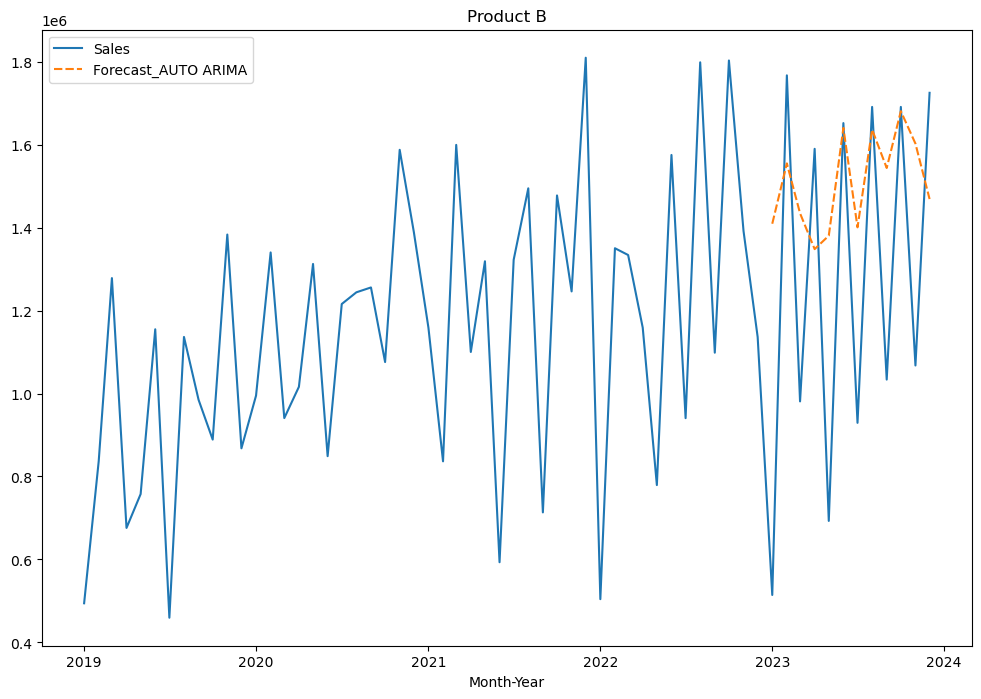

In [88]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_AUTO ARIMA']])
plt.title('Product B')

In [89]:
mae_auto_arima= mean_absolute_error(test,forecast_test_auto)
mape_auto_arima= mean_absolute_percentage_error(test,forecast_test_auto)
mse_auto_arima=mean_squared_error(test,forecast_test_auto)
rmse_auto_arima= np.sqrt(mean_squared_error(test,forecast_test_auto))

print(f'MAE - AUTO ARIMA: {mae_auto_arima}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima}')

MAE - AUTO ARIMA: 361595.78675793833
MAPE - AUTO ARIMA: 0.4301972486948735
MSE - AUTO ARIMA: 201684310197.0093
RMSE - AUTO ARIMA: 449092.7634654218


# FORECASTING

In [17]:
auto_arima_forecast= pm.auto_arima(sales_b['Sales'], start_p=0, d=1, start_q=0, max_p=5,max_q=3,
                          start_P=0, D=0, start_Q=0, max_P=5 ,max_Q=5 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_forecast

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1738.133, Time=0.04 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1733.214, Time=0.06 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1734.693, Time=0.27 sec
 ARIMA(0,1,0)(0,0,3)[12] intercept   : AIC=1736.690, Time=0.62 sec
 ARIMA(0,1,0)(0,0,4)[12] intercept   : AIC=1738.654, Time=1.99 sec
 ARIMA(0,1,0)(0,0,5)[12] intercept   : AIC=1740.615, Time=3.29 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1735.306, Time=0.06 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1734.731, Time=0.12 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1736.693, Time=0.34 sec
 ARIMA(0,1,0)(1,0,3)[12] intercept   : AIC=1738.681, Time=0.66 sec
 ARIMA(0,1,0)(1,0,4)[12] intercept   : AIC=1740.647, Time=4.63 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1735.351, Time=0.11 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1736.686, Time=0.28 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1738.664, Time=0.63 sec
 ARIMA(0,1,0)(2,0,3)[12] intercept   : AIC=1740.641, Time=2.10

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

In [19]:
forecast_autoarima= auto_arima_forecast.predict(n_periods=12)

In [20]:
forecast_autoarima

2024-01-01    9.034068e+05
2024-02-01    1.663361e+06
2024-03-01    1.123630e+06
2024-04-01    1.674414e+06
2024-05-01    1.158337e+06
2024-06-01    1.561497e+06
2024-07-01    1.274608e+06
2024-08-01    1.585575e+06
2024-09-01    1.317473e+06
2024-10-01    1.581144e+06
2024-11-01    1.346236e+06
2024-12-01    1.697106e+06
Freq: MS, dtype: float64

Text(0.5, 1.0, 'Product B')

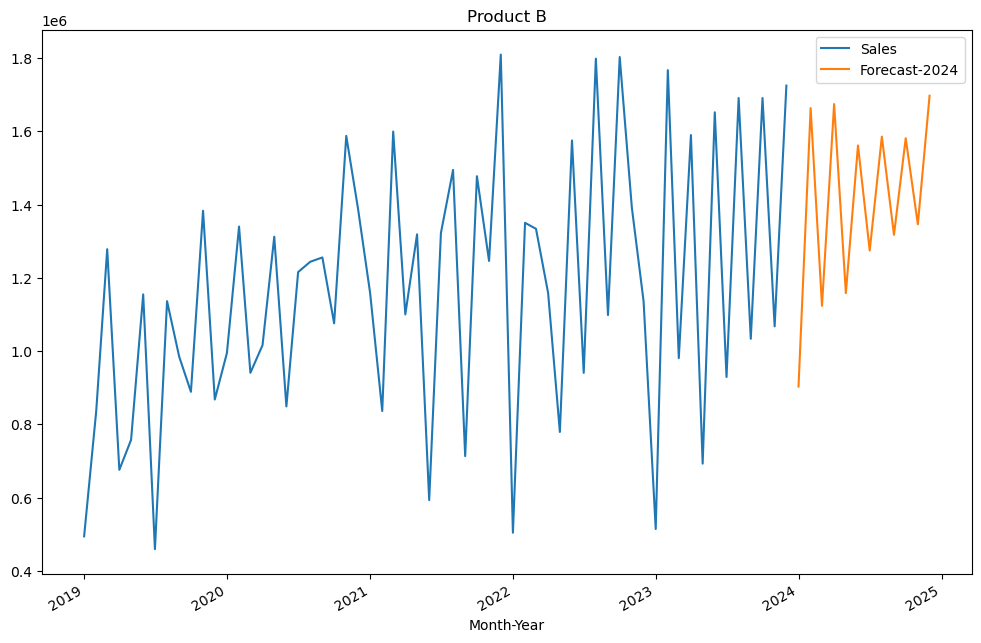

In [21]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales']])
forecast_autoarima.plot(legend=True, label='Forecast-2024')
plt.title('Product B')

In [22]:
sales_b.tail(12)

,Sales
Month-Year,
2023-01-01,514369
2023-02-01,1767039
2023-03-01,981026
2023-04-01,1589911
2023-05-01,692905
2023-06-01,1651940
2023-07-01,929333
2023-08-01,1690948
2023-09-01,1033615


In [23]:
sales_b.mean()

Sales    1.166948e+06
dtype: float64

In [90]:
data = {
    'model': ['ARIMA', 'AUTO ARIMA', 'SEASONAL ARIMA'],
    'MAE': [mae_arima, mae_auto_arima, mae_sarima],  
    'MAPE': [mape_arima, mape_auto_arima, mape_sarima],  
    'MSE': [mse_arima, mse_auto_arima, mse_sarima],  
    'RMSE': [rmse_arima, rmse_auto_arima, rmse_sarima]  
}

model_results = pd.DataFrame(data)
model_results.set_index('model', inplace=True)
model_results

,MAE,MAPE,MSE,RMSE
model,,,,
ARIMA,415980.172585,0.463603,2.194360e+11,468439.970656
AUTO ARIMA,361595.786758,0.430197,2.016843e+11,449092.763465
SEASONAL ARIMA,351873.141253,0.393583,1.619751e+11,402461.356484


# TESTING

In [18]:
auto_arima_1= pm.auto_arima(train, start_p=0, start_q=0, max_p=5,max_q=3,
                          start_P=0, start_Q=0, max_P=2 ,max_Q=2 ,  
                          stepwise=False, trace=True,
                          seasonal=True,m=12)
auto_arima_1

 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1374.393, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1376.384, Time=0.05 sec
 ARIMA(0,1,0)(0,0,2)[12] intercept   : AIC=1377.119, Time=0.12 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=1376.387, Time=0.05 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=1378.263, Time=0.08 sec
 ARIMA(0,1,0)(1,0,2)[12] intercept   : AIC=1378.671, Time=0.23 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=1377.144, Time=0.11 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=1378.530, Time=0.18 sec
 ARIMA(0,1,0)(2,0,2)[12] intercept   : AIC=1380.459, Time=0.35 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1350.206, Time=0.03 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1350.297, Time=0.06 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1351.489, Time=0.16 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1352.086, Time=0.06 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.21 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=0.86 sec
 ARIM

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(0, 0, 1, 12),
      suppress_warnings=True)

In [19]:
auto_arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(3, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -660.560
Date:                            Thu, 09 May 2024   AIC                           1335.120
Time:                                    13:34:54   BIC                           1348.071
Sample:                                01-01-2019   HQIC                          1339.994
                                     - 12-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.218e+04   2.76e+04      1.529      0.126   -1.19e+04    9.63e+04
ar.L1         -0.7728      0.212     -3.647      0.000      -1.188      -0.358
ar.L2         -0.4947      0.256     -1.934      0.053      -0.996       0.007
ar.L3         -0.3294      0.161     -2.051      0.040      -0.644      -0.015
ma.L1         -0.6157      0.175     -3.516      0.000      -0.959      -0.272
ma.S.L12       0.3138      0.234      1.340      0.180      -0.145       0.773
sigma2       8.38e+10      0.007   1.17e+13      0.000    8.38e+10    8.38e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.40   Prob(JB):                         0.64
Heteroskedasticity (H):               1.03   Skew:                            -0.17
Prob(H) (two-sided):                  0.96   Kurtosis:                         2.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.21e+29. Standard errors may be unstable.
"""

In [20]:
residuals_s= auto_arima_1.resid[1:]
fig,ax=plt.subplots(1,2, figsize=(14, 6))
residuals_s.plot(title='Residuals',ax=ax[0])
residuals_s.plot(title='Density',kind='kde',ax=ax[1])
plt.show()

TypeError: 'method' object is not subscriptable

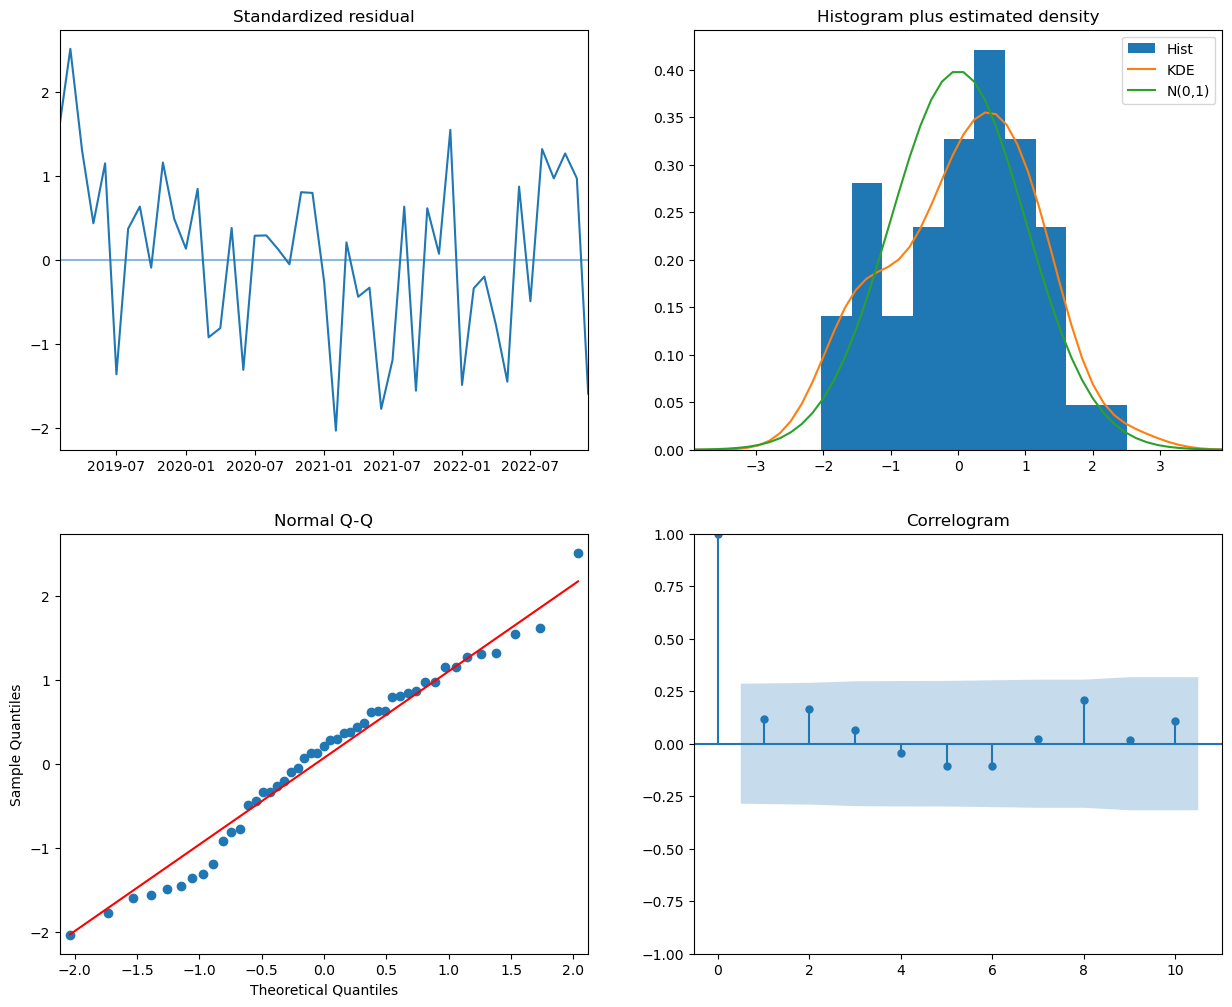

In [21]:
auto_arima_1.plot_diagnostics(figsize=(15, 12))
plt.show()

In [25]:
forecast_test_auto_1= auto_arima_1.predict(n_periods=len(test))
sales_b['Forecast_AUTO ARIMA_1']=[None]*len(train)+ list(forecast_test_auto_1)
#sales_b[['Sales','Forecast_AUTO ARIMA']].plot()

Text(0.5, 1.0, 'Product B')

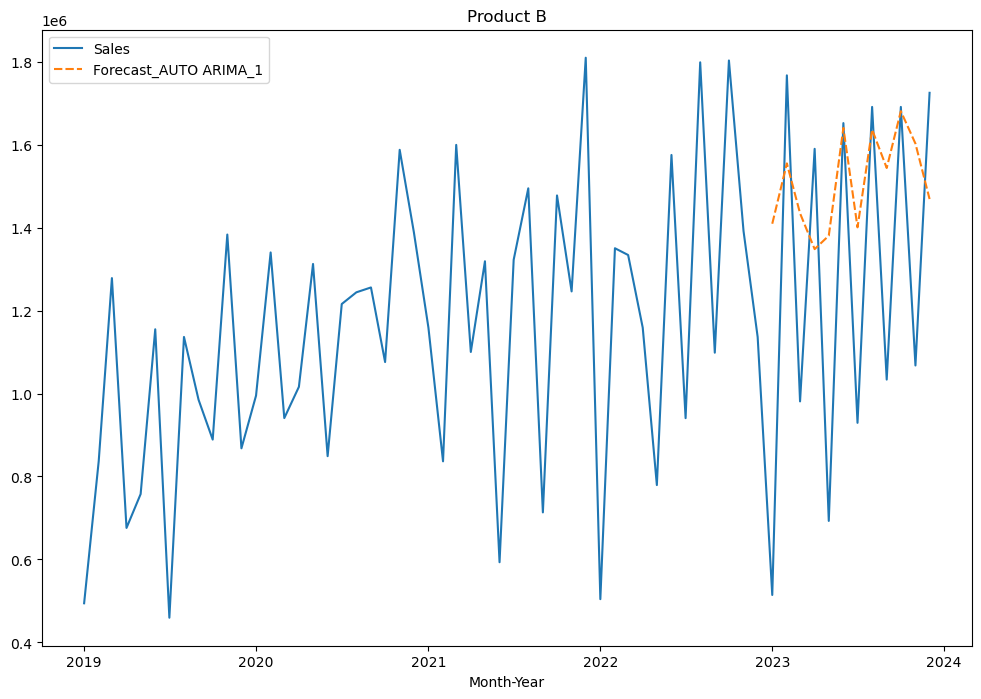

In [26]:
plt.figure(figsize=(12, 8))
sns.lineplot(sales_b[['Sales','Forecast_AUTO ARIMA_1']])
plt.title('Product B')

In [27]:
mae_auto_arima_1= mean_absolute_error(test,forecast_test_auto_1)
mape_auto_arima_1= mean_absolute_percentage_error(test,forecast_test_auto_1)
mse_auto_arima_1=mean_squared_error(test,forecast_test_auto_1)
rmse_auto_arima_1= np.sqrt(mean_squared_error(test,forecast_test_auto_1))

print(f'MAE - AUTO ARIMA: {mae_auto_arima_1}')
print(f'MAPE - AUTO ARIMA: {mape_auto_arima_1}')
print(f'MSE - AUTO ARIMA: {mse_auto_arima_1}')
print(f'RMSE - AUTO ARIMA: {rmse_auto_arima_1}')

MAE - AUTO ARIMA: 361595.78675793833
MAPE - AUTO ARIMA: 0.4301972486948735
MSE - AUTO ARIMA: 201684310197.0093
RMSE - AUTO ARIMA: 449092.7634654218
